In [1]:
# Import the required libraries and dependencies
import os
import pandas as pd
from pathlib import Path
import sqlalchemy
from sodapy import Socrata
import matplotlib.pyplot as plt
import hvplot.pandas
import numpy as np
import warnings
import datetime as dt
%matplotlib inline
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
# client = Socrata("data.seattle.gov", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.seattle.gov,
# #                  MyAppToken,
# #                  username="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("tazs-3rd5", limit=1000000)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)
# results_df

In [3]:
# use pandas to read the first csv file "SPD_Crimes_Early.csv"
spd_crimes_early = pd.read_csv("./Resources/SPD_Crimes_Early.csv", index_col='Offense ID')
format_str = '%d/%m/%Y'

# display the dateframe
spd_crimes_early['Report DateTime'] = spd_crimes_early['Report DateTime'].str.slice(0, 10)
spd_crimes_early['Report DateTime'] = pd.to_datetime(spd_crimes_early['Report DateTime'])
spd_crimes_early.head()

Report Number  Offense Start DateTime    Offense End DateTime  \
Offense ID                                                                  
12605873663   2020-044620  02/05/2020 10:10:00 AM                     NaN   
12605598696   2020-044452  02/03/2020 08:00:00 AM  02/04/2020 08:00:00 AM   
12605567653   2020-044465  02/02/2020 08:30:00 PM  02/02/2020 09:30:00 PM   
12605174036   2020-044225  02/05/2020 01:17:00 AM  02/05/2020 02:21:00 AM   
12605081469   2020-044076  02/05/2020 12:51:21 AM                     NaN   

            Report DateTime Group A B Crime Against Category  \
Offense ID                                                     
12605873663      2020-02-05         A                SOCIETY   
12605598696      2020-02-05         A               PROPERTY   
12605567653      2020-02-05         A               PROPERTY   
12605174036      2020-02-05         A               PROPERTY   
12605081469      2020-02-05         B                SOCIETY   

                                 Offense Parent Group  \
Offense ID                                              
12605873663                    DRUG/NARCOTIC OFFENSES   
12605598696                             LARCENY-THEFT   
12605567653                                   ROBBERY   
12605174036  DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY   
12605081469               DRIVING UNDER THE INFLUENCE   

                                                 Offense Offense Code  \
Offense ID                                                              
12605873663                     Drug/Narcotic Violations          35A   
12605598696  Theft of Motor Vehicle Parts or Accessories          23G   
12605567653                                      Robbery          120   
12605174036     Destruction/Damage/Vandalism of Property          290   
12605081469                  Driving Under the Influence          90D   

            Precinct Sector Beat               MCPP  \
Offense ID                                            
12605873663        W      Q   Q1           MAGNOLIA   
12605598696        N      J   J3  ROOSEVELT/RAVENNA   
12605567653        N      U   U3  ROOSEVELT/RAVENNA   
12605174036        W      Q   Q1           MAGNOLIA   
12605081469        N      B   B2      BALLARD SOUTH   

                        100 Block Address   Longitude   Latitude  
Offense ID                                                        
12605873663      32XX BLOCK OF 23RD AVE W -122.385974  47.649387  
12605598696      63XX BLOCK OF 5TH AVE NE -122.323399  47.675118  
12605567653  26TH AVE NE / NE BLAKELEY ST -122.299552  47.666384  
12605174036       22XX BLOCK OF W RAYE ST -122.384865  47.642927  
12605081469       NW 46TH ST / 8TH AVE NW -122.366195  47.662193

In [4]:
# drop any unnecessary columns
spd_crimes_early_revised = spd_crimes_early.drop(columns=[
    'Group A B', 
    'Offense Start DateTime', 
    'Offense End DateTime', 
    '100 Block Address',
    'Offense Code',
    'Precinct',
    'Sector',
    'Beat',
])

# display the dataframe
spd_crimes_early_revised.head()

Report Number Report DateTime Crime Against Category  \
Offense ID                                                         
12605873663   2020-044620      2020-02-05                SOCIETY   
12605598696   2020-044452      2020-02-05               PROPERTY   
12605567653   2020-044465      2020-02-05               PROPERTY   
12605174036   2020-044225      2020-02-05               PROPERTY   
12605081469   2020-044076      2020-02-05                SOCIETY   

                                 Offense Parent Group  \
Offense ID                                              
12605873663                    DRUG/NARCOTIC OFFENSES   
12605598696                             LARCENY-THEFT   
12605567653                                   ROBBERY   
12605174036  DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY   
12605081469               DRIVING UNDER THE INFLUENCE   

                                                 Offense               MCPP  \
Offense ID                                                                    
12605873663                     Drug/Narcotic Violations           MAGNOLIA   
12605598696  Theft of Motor Vehicle Parts or Accessories  ROOSEVELT/RAVENNA   
12605567653                                      Robbery  ROOSEVELT/RAVENNA   
12605174036     Destruction/Damage/Vandalism of Property           MAGNOLIA   
12605081469                  Driving Under the Influence      BALLARD SOUTH   

              Longitude   Latitude  
Offense ID                          
12605873663 -122.385974  47.649387  
12605598696 -122.323399  47.675118  
12605567653 -122.299552  47.666384  
12605174036 -122.384865  47.642927  
12605081469 -122.366195  47.662193

In [5]:
# check the file for duplicate information
spd_crimes_early_revised.duplicated().sum()

2144

In [6]:
# drop any duplicated data
spd_crimes_early_revised = spd_crimes_early_revised.drop_duplicates()

# check that there is no more duplicate information
spd_crimes_early_revised.duplicated().sum()

0

In [7]:
# check the file for any null information
spd_crimes_early_revised.isnull().sum()

Report Number             0
Report DateTime           0
Crime Against Category    0
Offense Parent Group      0
Offense                   0
MCPP                      0
Longitude                 0
Latitude                  0
dtype: int64

In [8]:
# check data types
spd_crimes_early_revised.dtypes

Report Number                     object
Report DateTime           datetime64[ns]
Crime Against Category            object
Offense Parent Group              object
Offense                           object
MCPP                              object
Longitude                        float64
Latitude                         float64
dtype: object

In [9]:
# check index data types
type(spd_crimes_early_revised.index)

pandas.core.indexes.numeric.Int64Index

In [10]:
# use pandas to read the second csv file "SPD_Crimes_Middle.csv"
spd_crimes_middle = pd.read_csv("./Resources/SPD_Crimes_Middle.csv", index_col='Offense ID')

# display the dataframe
spd_crimes_middle['Report DateTime'] = spd_crimes_middle['Report DateTime'].str.slice(0, 10)
spd_crimes_middle['Report DateTime'] = pd.to_datetime(spd_crimes_middle['Report DateTime'])
spd_crimes_middle.head()

Report Number  Offense Start DateTime    Offense End DateTime  \
Offense ID                                                                 
7682451747   2012-263978  08/10/2012 01:00:00 PM                     NaN   
7697933853   2012-263819  08/09/2012 05:30:00 PM  08/09/2012 06:45:00 PM   
7691687490   2012-263580  08/09/2012 08:15:00 AM  08/09/2012 03:00:00 PM   
7675128577   2012-903565  08/09/2012 12:00:00 AM  08/09/2012 06:00:00 AM   
7626650246   2012-263745  08/10/2012 11:40:00 AM                     NaN   

           Report DateTime Group A B Crime Against Category  \
Offense ID                                                    
7682451747      2012-08-10         A                SOCIETY   
7697933853      2012-08-10         A               PROPERTY   
7691687490      2012-08-10         A               PROPERTY   
7675128577      2012-08-10         A               PROPERTY   
7626650246      2012-08-10         A               PROPERTY   

              Offense Parent Group                    Offense Offense Code  \
Offense ID                                                                   
7682451747  DRUG/NARCOTIC OFFENSES  Drug Equipment Violations          35B   
7697933853           LARCENY-THEFT        Theft From Building          23D   
7691687490           LARCENY-THEFT   Theft From Motor Vehicle          23F   
7675128577           LARCENY-THEFT   Theft From Motor Vehicle          23F   
7626650246           LARCENY-THEFT            Purse-snatching          23B   

           Precinct Sector Beat                 MCPP  \
Offense ID                                             
7682451747        W      M   M3  DOWNTOWN COMMERCIAL   
7697933853        N      L   L2            NORTHGATE   
7691687490        W      M   M3  DOWNTOWN COMMERCIAL   
7675128577        W      Q   Q2           QUEEN ANNE   
7626650246        S      S   S1            NEW HOLLY   

                    100 Block Address   Longitude   Latitude  
Offense ID                                                    
7682451747      15XX BLOCK OF 3RD AVE -122.338247  47.610246  
7697933853   5XX BLOCK OF NE 103RD ST -122.321798  47.703131  
7691687490      12XX BLOCK OF 4TH AVE -122.334540  47.607871  
7675128577  13XX BLOCK OF W DRAVUS ST -122.374232  47.648473  
7626650246   76XX BLOCK OF 40TH AVE S -122.281847  47.533776

In [11]:
# reorganized spd crimes middle dataframe by dropping columns
spd_crimes_middle_revised = spd_crimes_middle.drop(columns=[
    'Group A B', 
    'Offense Start DateTime', 
    'Offense End DateTime', 
    '100 Block Address',
    'Offense Code',
    'Precinct',
    'Sector',
    'Beat',
])

# display the dataframe
spd_crimes_middle_revised.head()

Report Number Report DateTime Crime Against Category  \
Offense ID                                                        
7682451747   2012-263978      2012-08-10                SOCIETY   
7697933853   2012-263819      2012-08-10               PROPERTY   
7691687490   2012-263580      2012-08-10               PROPERTY   
7675128577   2012-903565      2012-08-10               PROPERTY   
7626650246   2012-263745      2012-08-10               PROPERTY   

              Offense Parent Group                    Offense  \
Offense ID                                                      
7682451747  DRUG/NARCOTIC OFFENSES  Drug Equipment Violations   
7697933853           LARCENY-THEFT        Theft From Building   
7691687490           LARCENY-THEFT   Theft From Motor Vehicle   
7675128577           LARCENY-THEFT   Theft From Motor Vehicle   
7626650246           LARCENY-THEFT            Purse-snatching   

                           MCPP   Longitude   Latitude  
Offense ID                                              
7682451747  DOWNTOWN COMMERCIAL -122.338247  47.610246  
7697933853            NORTHGATE -122.321798  47.703131  
7691687490  DOWNTOWN COMMERCIAL -122.334540  47.607871  
7675128577           QUEEN ANNE -122.374232  47.648473  
7626650246            NEW HOLLY -122.281847  47.533776

In [12]:
# check the file for duplicate information
spd_crimes_middle_revised.duplicated().sum()

2305

In [13]:
# drop any duplicated information
spd_crimes_middle_revised = spd_crimes_middle_revised.drop_duplicates()

# check that there is no more duplicate information
spd_crimes_middle_revised.duplicated().sum()

0

In [14]:
# drop null data
spd_crimes_middle_revised.isnull().sum()

Report Number             0
Report DateTime           0
Crime Against Category    0
Offense Parent Group      0
Offense                   0
MCPP                      0
Longitude                 0
Latitude                  0
dtype: int64

In [15]:
# check data types
spd_crimes_middle_revised.dtypes

Report Number                     object
Report DateTime           datetime64[ns]
Crime Against Category            object
Offense Parent Group              object
Offense                           object
MCPP                              object
Longitude                        float64
Latitude                         float64
dtype: object

In [16]:
# check index data types
type(spd_crimes_middle_revised.index)

pandas.core.indexes.numeric.Int64Index

In [17]:
# use pandas to read the third csv file "SPD_Crimes_Late.csv"
spd_crimes_late = pd.read_csv("./Resources/SPD_Crimes_Late.csv", index_col='Offense ID')

# display the dataframe
spd_crimes_late['Report DateTime'] = spd_crimes_late['Report DateTime'].str.slice(0, 10)
spd_crimes_late['Report DateTime'] = pd.to_datetime(spd_crimes_late['Report DateTime'])
spd_crimes_late.head()

Report Number  Offense Start DateTime    Offense End DateTime  \
Offense ID                                                                 
7675045429   2012-431647  12/18/2012 07:34:00 PM                     NaN   
7681564329   2012-431578  12/17/2012 07:00:00 AM  12/18/2012 06:00:00 PM   
7647361288   2012-431612  01/03/2012 08:00:00 AM  12/18/2012 06:40:00 PM   
7666250764   2012-431500  12/17/2012 06:29:00 PM                     NaN   
7700051108   2012-431593  12/18/2012 06:23:00 PM                     NaN   

           Report DateTime Group A B Crime Against Category  \
Offense ID                                                    
7675045429      2012-12-18         A                 PERSON   
7681564329      2012-12-18         A               PROPERTY   
7647361288      2012-12-18         A                 PERSON   
7666250764      2012-12-18         A               PROPERTY   
7700051108      2012-12-18         A               PROPERTY   

                  Offense Parent Group                       Offense  \
Offense ID                                                             
7675045429            ASSAULT OFFENSES                  Intimidation   
7681564329  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7647361288            ASSAULT OFFENSES                  Intimidation   
7666250764  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7700051108  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   

           Offense Code Precinct Sector Beat                 MCPP  \
Offense ID                                                          
7675045429          13C        W      M   M2  DOWNTOWN COMMERCIAL   
7681564329          220        W      Q   Q2           QUEEN ANNE   
7647361288          13C        W      D   D3          SLU/CASCADE   
7666250764          220        N      U   U1           UNIVERSITY   
7700051108          220        W      D   D2           QUEEN ANNE   

                       100 Block Address   Longitude   Latitude  
Offense ID                                                       
7675045429         15XX BLOCK OF 7TH AVE -122.333808  47.612103  
7681564329      30XX BLOCK OF 11TH AVE W -122.371535  47.647658  
7647361288  11XX BLOCK OF FAIRVIEW AVE N -122.328881  47.630301  
7666250764     52XX BLOCK OF 19TH AVE NE -122.307150  47.667464  
7700051108    24XX BLOCK OF DEXTER AVE N -122.344275  47.639951

In [18]:
spd_crimes_late_revised = spd_crimes_late.drop(columns=[
    'Group A B', 
    'Offense Start DateTime', 
    'Offense End DateTime', 
    '100 Block Address',
    'Offense Code',
    'Precinct',
    'Sector',
    'Beat',
])

# display the dataframe
spd_crimes_late_revised.head()

Report Number Report DateTime Crime Against Category  \
Offense ID                                                        
7675045429   2012-431647      2012-12-18                 PERSON   
7681564329   2012-431578      2012-12-18               PROPERTY   
7647361288   2012-431612      2012-12-18                 PERSON   
7666250764   2012-431500      2012-12-18               PROPERTY   
7700051108   2012-431593      2012-12-18               PROPERTY   

                  Offense Parent Group                       Offense  \
Offense ID                                                             
7675045429            ASSAULT OFFENSES                  Intimidation   
7681564329  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7647361288            ASSAULT OFFENSES                  Intimidation   
7666250764  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7700051108  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   

                           MCPP   Longitude   Latitude  
Offense ID                                              
7675045429  DOWNTOWN COMMERCIAL -122.333808  47.612103  
7681564329           QUEEN ANNE -122.371535  47.647658  
7647361288          SLU/CASCADE -122.328881  47.630301  
7666250764           UNIVERSITY -122.307150  47.667464  
7700051108           QUEEN ANNE -122.344275  47.639951

In [19]:
# check the file for duplicate information
spd_crimes_late_revised.duplicated().sum()

1034

In [20]:
# drop any duplicated information
spd_crimes_late_revised = spd_crimes_late_revised.drop_duplicates()

# check that there is no more duplicate information
spd_crimes_late_revised.duplicated().sum()

0

In [21]:
# drop any null data
spd_crimes_late_revised.isnull().sum()

Report Number             0
Report DateTime           0
Crime Against Category    0
Offense Parent Group      0
Offense                   0
MCPP                      0
Longitude                 0
Latitude                  0
dtype: int64

In [22]:
# check data types
spd_crimes_late_revised.dtypes

Report Number                     object
Report DateTime           datetime64[ns]
Crime Against Category            object
Offense Parent Group              object
Offense                           object
MCPP                              object
Longitude                        float64
Latitude                         float64
dtype: object

In [23]:
# check index data type
type(spd_crimes_late_revised.index)

pandas.core.indexes.numeric.Int64Index

In [24]:
# join all three dataframes together
concat = pd.concat([spd_crimes_early_revised, spd_crimes_middle_revised, spd_crimes_late_revised]).sort_values("Report DateTime", ascending=True).rename(columns={"MCPP":"Neighborhood"})
concat.head()

Report Number Report DateTime Crime Against Category  \
Offense ID                                                        
7647383752   2008-000095      2008-01-01                 PERSON   
7699117404   2008-000499      2008-01-01               PROPERTY   
7676934711   2008-000518      2008-01-01               PROPERTY   
7696469661   2008-000542      2008-01-01               PROPERTY   
7627663810   2008-000519      2008-01-01               PROPERTY   

           Offense Parent Group                   Offense     Neighborhood  \
Offense ID                                                                   
7647383752     ASSAULT OFFENSES        Aggravated Assault       QUEEN ANNE   
7699117404        LARCENY-THEFT  Theft From Motor Vehicle  BRIGHTON/DUNLAP   
7676934711        LARCENY-THEFT  Theft From Motor Vehicle      WALLINGFORD   
7696469661        LARCENY-THEFT       Theft From Building       UNIVERSITY   
7627663810        LARCENY-THEFT         All Other Larceny           MORGAN   

             Longitude   Latitude  
Offense ID                         
7647383752 -122.347561  47.625852  
7699117404 -122.277611  47.531546  
7676934711 -122.334870  47.669807  
7696469661 -122.308315  47.665635  
7627663810 -122.387294  47.537622

In [25]:
concat = concat[~concat['Neighborhood'].isin(['UNKNOWN', '<Null>'])]
# concat.drop(concat[(concat['Neighborhood'] =='UNKNOWN')].index)
concat.head()


Report Number Report DateTime Crime Against Category  \
Offense ID                                                        
7647383752   2008-000095      2008-01-01                 PERSON   
7699117404   2008-000499      2008-01-01               PROPERTY   
7676934711   2008-000518      2008-01-01               PROPERTY   
7696469661   2008-000542      2008-01-01               PROPERTY   
7627663810   2008-000519      2008-01-01               PROPERTY   

           Offense Parent Group                   Offense     Neighborhood  \
Offense ID                                                                   
7647383752     ASSAULT OFFENSES        Aggravated Assault       QUEEN ANNE   
7699117404        LARCENY-THEFT  Theft From Motor Vehicle  BRIGHTON/DUNLAP   
7676934711        LARCENY-THEFT  Theft From Motor Vehicle      WALLINGFORD   
7696469661        LARCENY-THEFT       Theft From Building       UNIVERSITY   
7627663810        LARCENY-THEFT         All Other Larceny           MORGAN   

             Longitude   Latitude  
Offense ID                         
7647383752 -122.347561  47.625852  
7699117404 -122.277611  47.531546  
7676934711 -122.334870  47.669807  
7696469661 -122.308315  47.665635  
7627663810 -122.387294  47.537622

In [26]:
# calculate the amount of occurrence per each crime type
occurrence_df = concat.groupby(["Offense Parent Group"]).size()
occurrence_df

Offense Parent Group
ANIMAL CRUELTY                                 120
ARSON                                         1785
ASSAULT OFFENSES                            143755
BAD CHECKS                                    6539
BRIBERY                                         16
BURGLARY/BREAKING&ENTERING                  114140
COUNTERFEITING/FORGERY                        5160
CURFEW/LOITERING/VAGRANCY VIOLATIONS           888
DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY     93319
DRIVING UNDER THE INFLUENCE                  17708
DRUG/NARCOTIC OFFENSES                       24463
DRUNKENNESS                                     20
EMBEZZLEMENT                                  1960
EXTORTION/BLACKMAIL                            827
FAMILY OFFENSES, NONVIOLENT                  10021
FRAUD OFFENSES                               57301
GAMBLING OFFENSES                               26
HOMICIDE OFFENSES                              469
HUMAN TRAFFICKING                               49
KIDNAPPING

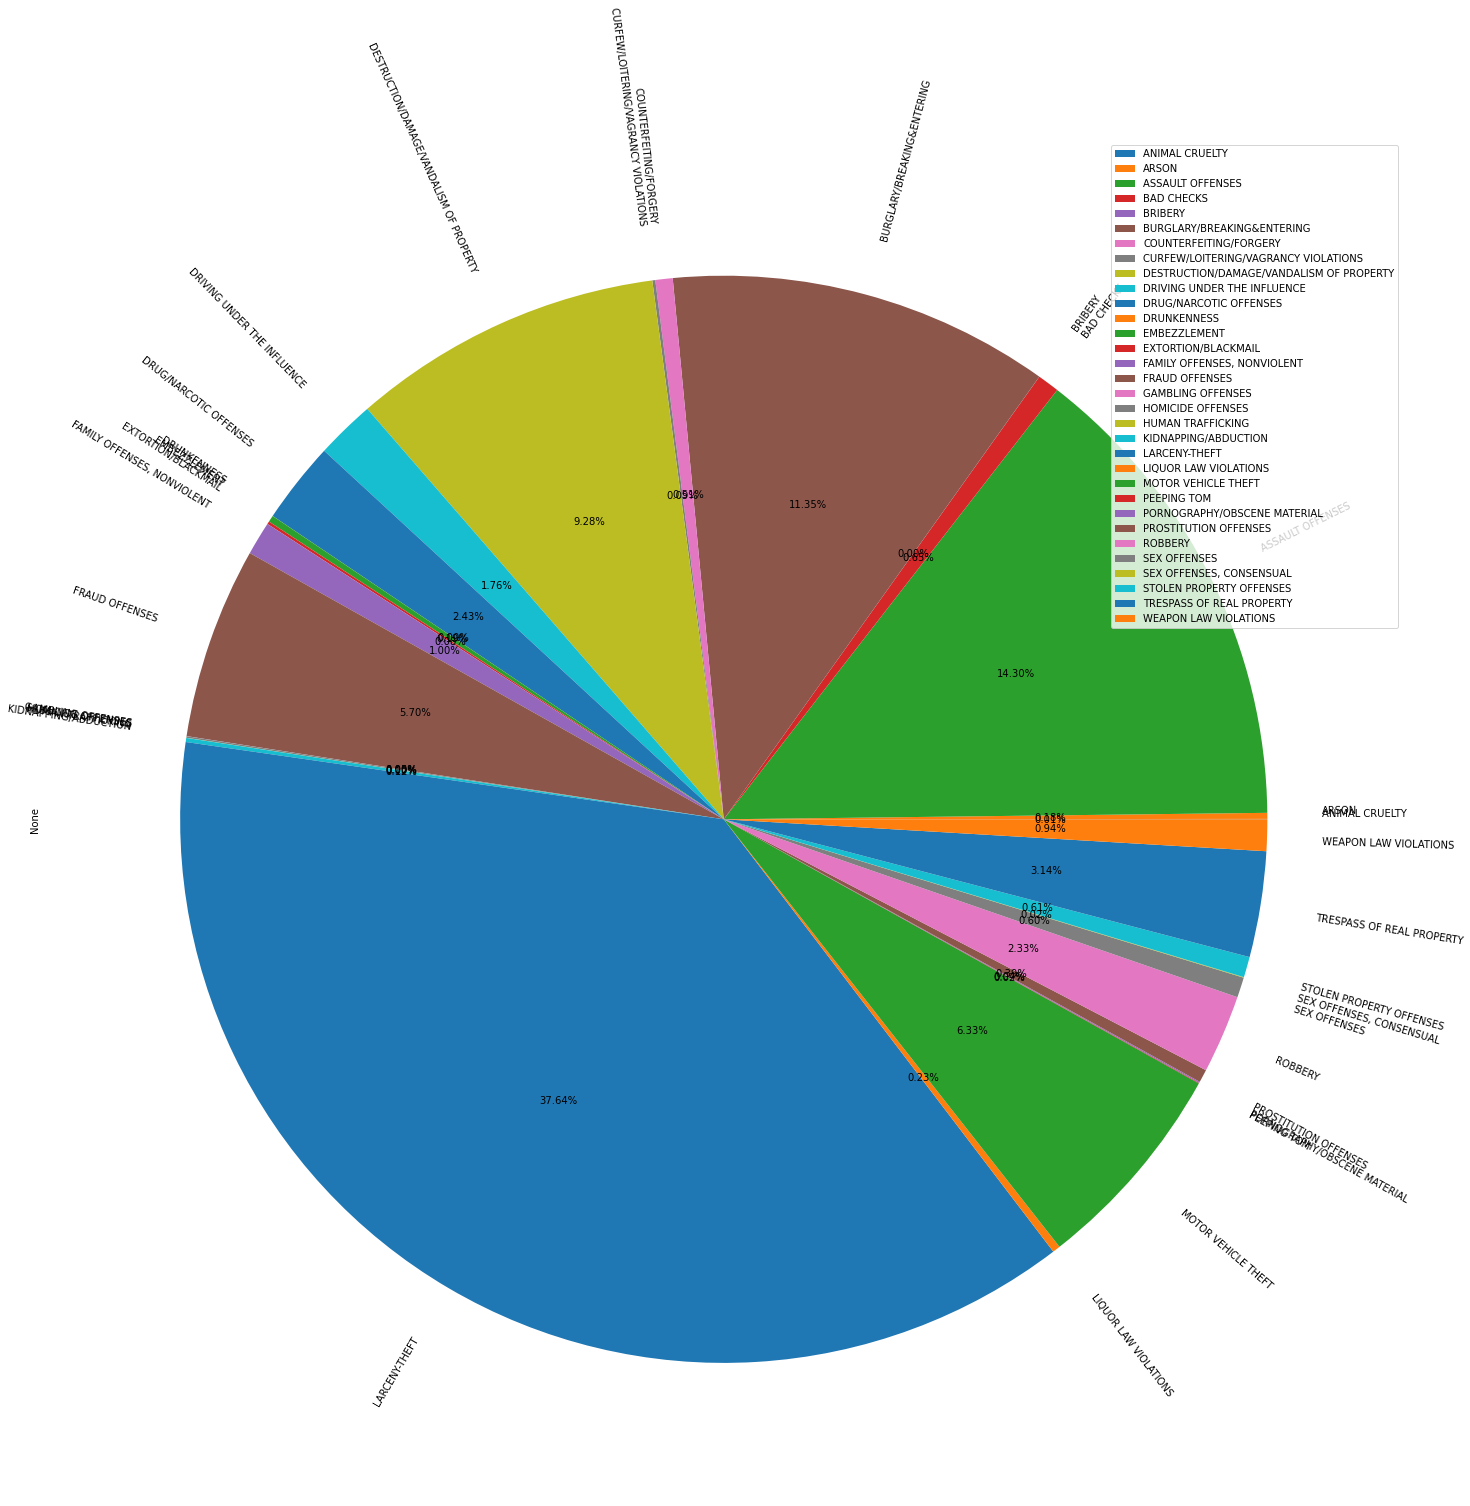

In [27]:
# create a pie plot
occurrence_df_plot = occurrence_df.plot(
    kind="pie",
    figsize=(25, 25),
    autopct='%1.2f%%',
    #explode=explode,
    rotatelabels=True
)

occurrence_df_plot.legend(loc="upper right")


In [28]:
# calculate the amount of occurrences per date
occurrence_by_date_df = concat.groupby(["Report DateTime","Offense Parent Group"]).size()
occurrence_by_date_df

Report DateTime  Offense Parent Group                    
2008-01-01       ASSAULT OFFENSES                            52
                 BAD CHECKS                                   1
                 BURGLARY/BREAKING&ENTERING                  12
                 COUNTERFEITING/FORGERY                       1
                 DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY    26
                                                             ..
2022-12-03       LARCENY-THEFT                                8
                 MOTOR VEHICLE THEFT                          7
                 ROBBERY                                      1
                 SEX OFFENSES                                 2
                 STOLEN PROPERTY OFFENSES                     1
Length: 84567, dtype: int64

In [29]:
# create an interactive plot
occurrence_by_date_plot = occurrence_by_date_df.hvplot.line(x="Report DateTime", ylabel="Amount of Occurrences",
                                                            groupby="Offense Parent Group",
                                                            title="2008-2021 Amount of Crimes in Seattle by Report Date and Type",
                                                            sort_date=True,
                                                            rot=90, frame_height=400, frame_width=1000)
occurrence_by_date_plot

:DynamicMap   [Offense Parent Group]
   :Curve   [Report DateTime]   (0)

In [30]:
# calculate the amount of occurrences per neighborhood
occurrence_by_neighborhood_df = concat.groupby(["Neighborhood","Report DateTime"]).size()
occurrence_by_neighborhood_df

Neighborhood     Report DateTime
ALASKA JUNCTION  2008-01-01         1
                 2008-01-02         3
                 2008-01-03         1
                 2008-01-04         1
                 2008-01-05         2
                                   ..
WALLINGFORD      2022-11-26         3
                 2022-11-27         1
                 2022-11-29         1
                 2022-11-30         6
                 2022-12-01         1
Length: 242062, dtype: int64

In [31]:
# create an interactive plot
occurrence_by_neighborhood_plot = occurrence_by_neighborhood_df.hvplot.line(
    x="Report DateTime",
    ylabel="Amount of Occurrences",
    groupby="Neighborhood",
    title="2008-2021 Amount of Crimes in Seattle by Report Date and Type",
    sort_date=True,
    rot=90, 
    frame_height=400,
    frame_width=1000
)
occurrence_by_neighborhood_plot

:DynamicMap   [Neighborhood]
   :Curve   [Report DateTime]   (0)

In [32]:
# calculate the amount of occurrences of assault from 2008-2010
assault_2008_2010_df = concat[(concat['Offense Parent Group'] == 'ASSAULT OFFENSES') & (concat['Report DateTime'] >= '2008-01-01') & (concat['Report DateTime'] <= '2008-12-31')]
assault_2008_2010_df.head()

Report Number Report DateTime Crime Against Category  \
Offense ID                                                        
7647383752   2008-000095      2008-01-01                 PERSON   
7688363527   2008-000136      2008-01-01                 PERSON   
7636701795   2008-000778      2008-01-01                 PERSON   
7698006211   2008-000342      2008-01-01                 PERSON   
7694140463   2008-000798      2008-01-01                 PERSON   

           Offense Parent Group             Offense   Neighborhood  \
Offense ID                                                           
7647383752     ASSAULT OFFENSES  Aggravated Assault     QUEEN ANNE   
7688363527     ASSAULT OFFENSES      Simple Assault     QUEEN ANNE   
7636701795     ASSAULT OFFENSES        Intimidation  HIGHLAND PARK   
7698006211     ASSAULT OFFENSES      Simple Assault     BITTERLAKE   
7694140463     ASSAULT OFFENSES        Intimidation      NORTHGATE   

             Longitude   Latitude  
Offense ID                         
7647383752 -122.347561  47.625852  
7688363527 -122.347594  47.621757  
7636701795 -122.347416  47.531930  
7698006211 -122.355553  47.725955  
7694140463 -122.332587  47.705023

In [33]:
# calculate the amount of occurrences of burglary from 2008-2010
burglary_2008_2010_df = concat[(concat['Offense Parent Group'] == 'BURGLARY/BREAKING&ENTERING') & (concat['Report DateTime'] >= '2008-01-01') & (concat['Report DateTime'] <= '2008-12-31')]
burglary_2008_2010_df.head()

Report Number Report DateTime Crime Against Category  \
Offense ID                                                        
7639236600   2008-001158      2008-01-01               PROPERTY   
7693830674   2008-001029      2008-01-01               PROPERTY   
7631973962   2008-001037      2008-01-01               PROPERTY   
7644188260   2008-001172      2008-01-01               PROPERTY   
7693459526   2008-001051      2008-01-01               PROPERTY   

                  Offense Parent Group                       Offense  \
Offense ID                                                             
7639236600  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7693830674  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7631973962  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7644188260  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   
7693459526  BURGLARY/BREAKING&ENTERING  Burglary/Breaking & Entering   

               Neighborhood   Longitude   Latitude  
Offense ID                                          
7639236600         LAKECITY -122.308715  47.700314  
7693830674       QUEEN ANNE -122.356743  47.620357  
7631973962       UNIVERSITY -122.318731  47.670058  
7644188260       QUEEN ANNE -122.367025  47.625594  
7693459526  ALASKA JUNCTION -122.397092  47.555681

In [34]:
# calculate the amount of occurrences of motor vehicle theft from 2008-2010
mvt_2008_2010_df = concat[(concat['Offense Parent Group'] == 'MOTOR VEHICLE THEFT') & (concat['Report DateTime'] >= '2008-01-01') & (concat['Report DateTime'] <= '2010-12-31')]
mvt_2008_2010_df = mvt_2008_2010_df.groupby(['Offense Parent Group','Report DateTime']).size()
mvt_2008_2010_df = mvt_2008_2010_df.reset_index()
mvt_2008_2010_df = mvt_2008_2010_df.rename(columns={0: "Amount of Occurences"})
mvt_2008_2010_df = mvt_2008_2010_df.set_index("Report DateTime")
mvt_2008_2010_df

Offense Parent Group  Amount of Occurences
Report DateTime                                           
2008-01-01       MOTOR VEHICLE THEFT                    11
2008-01-02       MOTOR VEHICLE THEFT                    11
2008-01-03       MOTOR VEHICLE THEFT                     7
2008-01-04       MOTOR VEHICLE THEFT                     4
2008-01-05       MOTOR VEHICLE THEFT                     6
...                              ...                   ...
2010-12-27       MOTOR VEHICLE THEFT                     6
2010-12-28       MOTOR VEHICLE THEFT                    12
2010-12-29       MOTOR VEHICLE THEFT                     6
2010-12-30       MOTOR VEHICLE THEFT                     5
2010-12-31       MOTOR VEHICLE THEFT                     5

[1096 rows x 2 columns]

In [35]:
# calculate the amount of occurrences of burglary from 2008-2010
burglary_2008_2010_df = concat[(concat['Offense Parent Group'] == 'BURGLARY/BREAKING&ENTERING') & (concat['Report DateTime'] >= '2008-01-01') & (concat['Report DateTime'] <= '2010-12-31')]
burglary_2008_2010_df = burglary_2008_2010_df.groupby(['Offense Parent Group','Report DateTime']).size()
burglary_2008_2010_df = burglary_2008_2010_df.reset_index()
burglary_2008_2010_df = burglary_2008_2010_df.rename(columns={0: "Amount of Occurences"})
burglary_2008_2010_df = burglary_2008_2010_df.set_index("Report DateTime")
burglary_2008_2010_df

Offense Parent Group  Amount of Occurences
Report DateTime                                                  
2008-01-01       BURGLARY/BREAKING&ENTERING                    12
2008-01-02       BURGLARY/BREAKING&ENTERING                    25
2008-01-03       BURGLARY/BREAKING&ENTERING                    27
2008-01-04       BURGLARY/BREAKING&ENTERING                    24
2008-01-05       BURGLARY/BREAKING&ENTERING                    21
...                                     ...                   ...
2010-12-27       BURGLARY/BREAKING&ENTERING                    31
2010-12-28       BURGLARY/BREAKING&ENTERING                    19
2010-12-29       BURGLARY/BREAKING&ENTERING                    28
2010-12-30       BURGLARY/BREAKING&ENTERING                    14
2010-12-31       BURGLARY/BREAKING&ENTERING                    18

[1096 rows x 2 columns]

In [36]:
# calculate the amount of occurrences of Assault from 2008-2010
assault_2008_2010_df = concat[(concat['Offense Parent Group'] == 'ASSAULT OFFENSES') & (concat['Report DateTime'] >= '2008-01-01') & (concat['Report DateTime'] <= '2010-12-31')]
assault_2008_2010_df = assault_2008_2010_df.groupby(['Offense Parent Group','Report DateTime']).size()
assault_2008_2010_df = assault_2008_2010_df.reset_index()
assault_2008_2010_df = assault_2008_2010_df.rename(columns={0: "Amount of Occurences"})
assault_2008_2010_df = assault_2008_2010_df.set_index("Report DateTime")
assault_2008_2010_df

Offense Parent Group  Amount of Occurences
Report DateTime                                           
2008-01-01          ASSAULT OFFENSES                    52
2008-01-02          ASSAULT OFFENSES                    15
2008-01-03          ASSAULT OFFENSES                    15
2008-01-04          ASSAULT OFFENSES                    25
2008-01-05          ASSAULT OFFENSES                    25
...                              ...                   ...
2010-12-27          ASSAULT OFFENSES                    20
2010-12-28          ASSAULT OFFENSES                    22
2010-12-29          ASSAULT OFFENSES                    20
2010-12-30          ASSAULT OFFENSES                    24
2010-12-31          ASSAULT OFFENSES                    31

[1096 rows x 2 columns]

<AxesSubplot:title={'center':'2008-2010 Assault, Burglary, and Motor Vehicle Theft Crimes by Date in Seattle, Washington'}, xlabel='Report DateTime', ylabel='Amount of Occurences'>

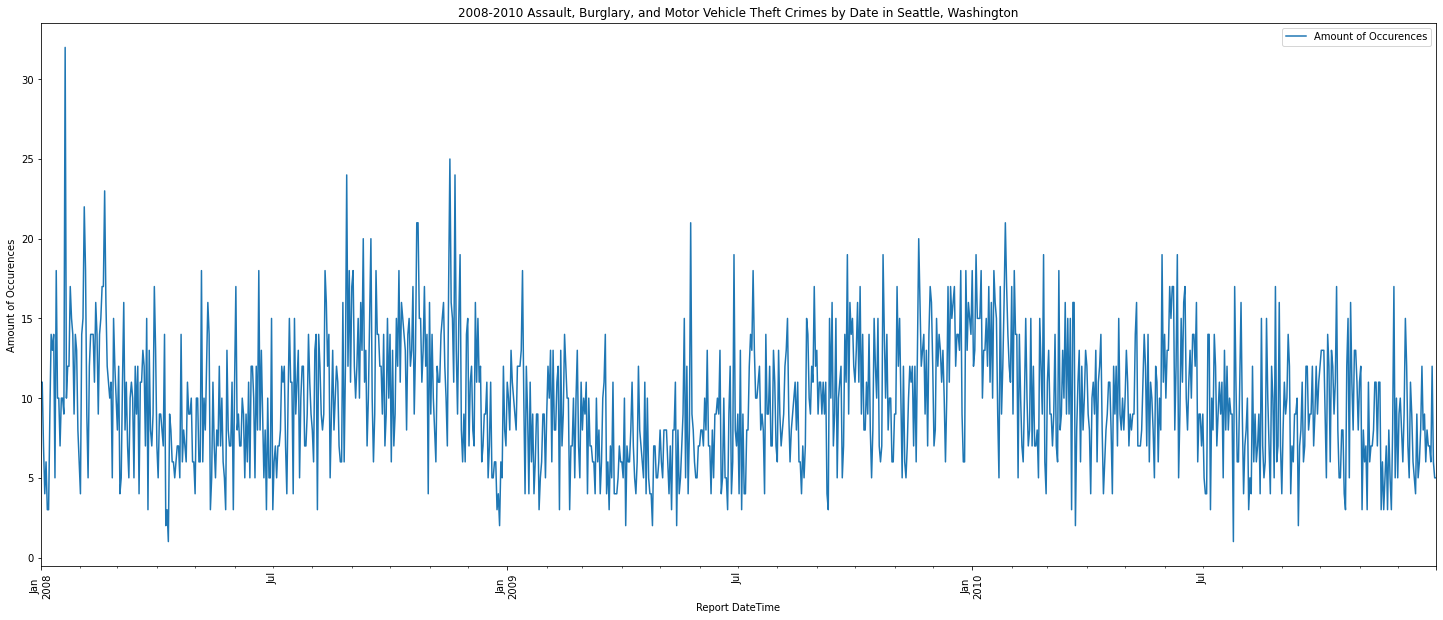

In [37]:
# plot all three crimes together on the same plot
crimes_2008_2010_plot = mvt_2008_2010_df.plot(
    kind='line',
    y='Amount of Occurences',
    figsize=(25,10),
    title='2008-2010 Assault, Burglary, and Motor Vehicle Theft Crimes by Date in Seattle, Washington',
    rot=90,
    ylabel="Amount of Occurences",
    legend=True
)

crimes_2008_2010_plot

<AxesSubplot:title={'center':'Amount of Occurences of Motor Vehicle Theft, Assault and Burglary in Seattle from 2008 - 2010'}, xlabel='Report DateTime', ylabel='Amount of Occurences'>

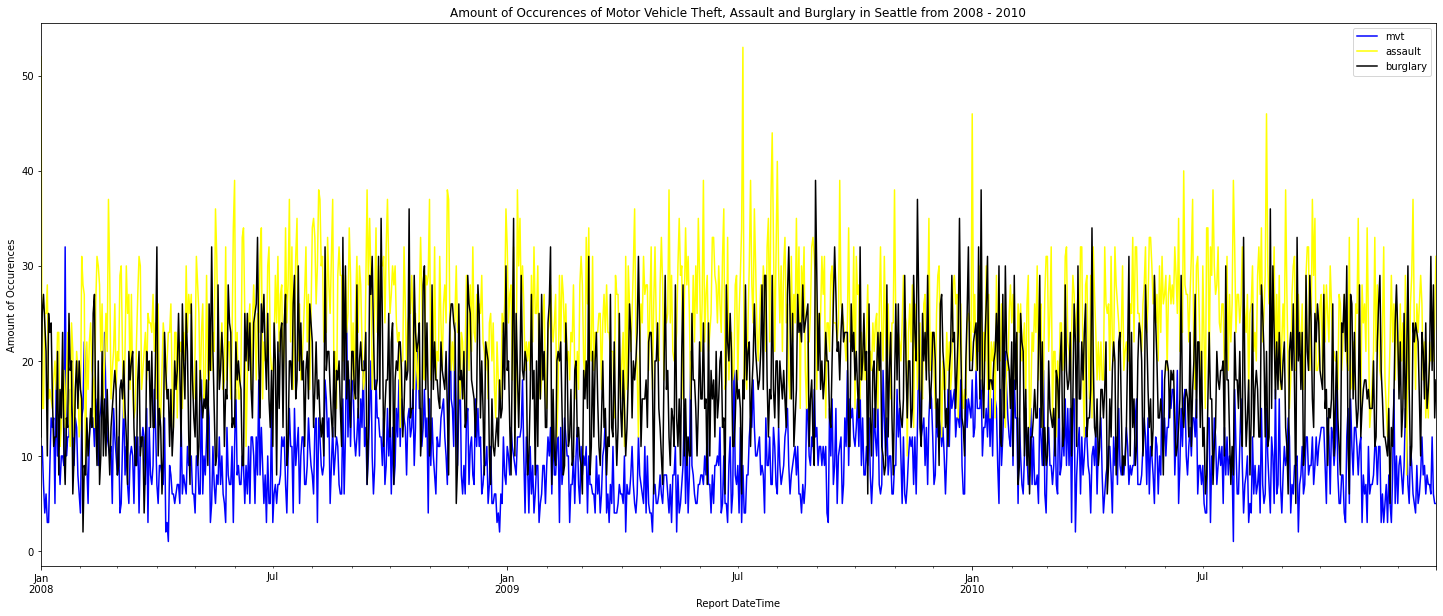

In [38]:
mvt_2008_2010_df["Amount of Occurences"].plot(
    legend=True,
    figsize=(25,10),
    title="Amount of Occurences of Motor Vehicle Theft, Assault and Burglary in Seattle from 2008 - 2010",
    color="blue",
    label="mvt",
    xlabel="Time",
    ylabel="Amount of Occurences"
)

assault_2008_2010_df["Amount of Occurences"].plot(
    legend=True,
    color="yellow",
    label="assault"
)

burglary_2008_2010_df["Amount of Occurences"].plot(
    legend=True,
    color="black",
    label="burglary"
)

In [39]:
# calculate the amount of occurrences of assault from 2018-2020
assault_2018_2020_df = concat[(concat['Offense Parent Group'] == 'ASSAULT OFFENSES') & (concat['Report DateTime'] >= '2018-01-01') & (concat['Report DateTime'] <= '2010-12-31')]
assault_2018_2020_df = assault_2018_2020_df.groupby(['Offense Parent Group','Report DateTime']).size()
assault_2018_2020_df = assault_2018_2020_df.reset_index()
assault_2018_2020_df = assault_2018_2020_df.rename(columns={0: "Amount of Occurences"})
assault_2018_2020_df = assault_2018_2020_df.set_index("Report DateTime")
assault_2018_2020_df

Empty DataFrame
Columns: [Offense Parent Group, Amount of Occurences]
Index: []

In [40]:
# calculate the amount of occurrences of burglary from 2018-2020


In [41]:
# calculate the amount of occurrences of motor vehicle theft from 2018-2020


In [42]:
# plot all three crimes together on the same plot


In [43]:
neighborhood_csv = pd.read_csv(
    Path("Resources/Locations.csv"),
    index_col="Neighborhood"
)

neighborhood_csv.head()

Lat       Lon
Neighborhood                      
ALASKA JUNCTION  47.5612 -122.3866
ALKI             47.5755 -122.4107
BALLARD NORTH    47.6611 -122.3265
BALLARD SOUTH    47.6659 -122.3830
BELLTOWN         47.6147 -122.3448

In [44]:
neighborhood_data_df = concat.groupby(["Neighborhood"]).size()
neighborhood_data_df.head()

Neighborhood
ALASKA JUNCTION    14481
ALKI                5218
BALLARD NORTH      20884
BALLARD SOUTH      32199
BELLTOWN           27481
dtype: int64

In [45]:
all_neighborhood_data_df = pd.concat(
    [neighborhood_data_df, neighborhood_csv],
    axis="columns",
    sort=False
).dropna()

all_neighborhood_data_df.head()

0      Lat       Lon
Neighborhood                             
ALASKA JUNCTION  14481  47.5612 -122.3866
ALKI              5218  47.5755 -122.4107
BALLARD NORTH    20884  47.6611 -122.3265
BALLARD SOUTH    32199  47.6659 -122.3830
BELLTOWN         27481  47.6147 -122.3448

In [46]:
all_neighborhood_data_df = all_neighborhood_data_df.rename(columns={0: "Amount of Occurences"})
all_neighborhood_data_df = all_neighborhood_data_df.reset_index()
all_neighborhood_data_df.head()

Neighborhood  Amount of Occurences      Lat       Lon
0  ALASKA JUNCTION                 14481  47.5612 -122.3866
1             ALKI                  5218  47.5755 -122.4107
2    BALLARD NORTH                 20884  47.6611 -122.3265
3    BALLARD SOUTH                 32199  47.6659 -122.3830
4         BELLTOWN                 27481  47.6147 -122.3448

In [60]:
# create a geoviews plot using groupby
# Rachel says use opts y formatter to make stuff look good!
occurrence_by_neighborhood_geoviews = all_neighborhood_data_df.hvplot.points(
    "Lon",
    "Lat",
    geo=True,
    size=500,
    color="Amount of Occurences",
    frame_width=1000, 
    frame_height=1000, 
    tiles="OSM",
    title="2008-2022 Crime by Neighborhood Seattle, Washington",
    alpha=0.8,
    xlabel="Latitude",
    ylabel="Longitude"
)
occurrence_by_neighborhood_geoviews

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (Amount of Occurences)

In [48]:
# calculate the mean amount of occurrences per neighborhood


In [49]:
# create an interactive plot


In [50]:
# create a geoviews plot using groupby


In [51]:
# calculate the amount of occurrences by date for September 1, 2008 - December 31, 2008
concat_2008_df = concat[(concat['Report DateTime'] > '2008-09-01') & (concat['Report DateTime'] <= '2008-12-31')]

concat_2008_occurences = concat_2008_df.groupby(["Report DateTime","Offense Parent Group"]).size()
display(concat_2008_occurences)

Report DateTime  Offense Parent Group                
2008-09-02       ASSAULT OFFENSES                        24
                 BAD CHECKS                               2
                 BURGLARY/BREAKING&ENTERING              21
                 COUNTERFEITING/FORGERY                   2
                 CURFEW/LOITERING/VAGRANCY VIOLATIONS     1
                                                         ..
2008-12-31       MOTOR VEHICLE THEFT                      7
                 PROSTITUTION OFFENSES                    1
                 ROBBERY                                  5
                 TRESPASS OF REAL PROPERTY                3
                 WEAPON LAW VIOLATIONS                    2
Length: 1964, dtype: int64

In [52]:
# create an interactive plot
concat_2008_plot = concat_2008_occurences.hvplot.line(
    x="Report DateTime",
    ylabel="Amount of Occurrences",
    groupby="Offense Parent Group",
    title="2012 Amount of Crimes in Seattle by Report Date and Type",
    rot=90, 
    frame_height=400, 
    frame_width=900
)

concat_2008_plot

:DynamicMap   [Offense Parent Group]
   :Curve   [Report DateTime]   (0)

In [53]:
# calculate the amount of occurrences by date for September 1, 2012 - December 31, 2008
concat_2012_df = concat[(concat['Report DateTime'] > '2012-09-01') & (concat['Report DateTime'] <= '2012-12-31')]

concat_2012_occurences = concat_2012_df.groupby(["Report DateTime","Offense Parent Group"]).size()
display(concat_2012_occurences)

Report DateTime  Offense Parent Group                    
2012-09-02       ASSAULT OFFENSES                            28
                 BAD CHECKS                                   1
                 BURGLARY/BREAKING&ENTERING                   7
                 DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY    10
                 DRIVING UNDER THE INFLUENCE                  3
                                                             ..
2012-12-31       ROBBERY                                      2
                 SEX OFFENSES                                 1
                 STOLEN PROPERTY OFFENSES                     2
                 TRESPASS OF REAL PROPERTY                    2
                 WEAPON LAW VIOLATIONS                        2
Length: 1821, dtype: int64

In [54]:
# create an interactive plot
concat_2012_plot = concat_2012_occurences.hvplot.line(
    x="Report DateTime",
    ylabel="Amount of Occurrences",
    groupby="Offense Parent Group",
    title="2012 Amount of Crimes in Seattle by Report Date and Type",
    rot=90, 
    frame_height=400, 
    frame_width=900
)

concat_2012_plot

:DynamicMap   [Offense Parent Group]
   :Curve   [Report DateTime]   (0)

In [55]:
# calculate the amount of occurrences by date for September 1, 2016 - December 31, 2016
concat_2016_df = concat[(concat['Report DateTime'] > '2016-09-01') & (concat['Report DateTime'] <= '2016-12-31')]

concat_2016_occurences = concat_2016_df.groupby(["Report DateTime","Offense Parent Group"]).size()
display(concat_2016_occurences)

Report DateTime  Offense Parent Group                    
2016-09-02       ASSAULT OFFENSES                            24
                 BAD CHECKS                                   2
                 BURGLARY/BREAKING&ENTERING                  27
                 COUNTERFEITING/FORGERY                       1
                 DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY    10
                                                             ..
2016-12-31       ROBBERY                                      1
                 SEX OFFENSES                                 1
                 STOLEN PROPERTY OFFENSES                     2
                 TRESPASS OF REAL PROPERTY                   12
                 WEAPON LAW VIOLATIONS                        3
Length: 1871, dtype: int64

In [56]:
# create an interactive plot
concat_2016_plot = concat_2016_occurences.hvplot.line(
    x="Report DateTime",
    ylabel="Amount of Occurrences",
    groupby="Offense Parent Group",
    title="2012 Amount of Crimes in Seattle by Report Date and Type",
    rot=90, 
    frame_height=400, 
    frame_width=900
)

concat_2016_plot

:DynamicMap   [Offense Parent Group]
   :Curve   [Report DateTime]   (0)

In [57]:
# calculate the amount of occurrences by date for September 1, 2020 - December 31, 2020
concat_2020_df = concat[(concat['Report DateTime'] > '2020-09-01') & (concat['Report DateTime'] <= '2020-12-31')]

concat_2020_occurences = concat_2020_df.groupby(["Report DateTime","Offense Parent Group"]).size()
display(concat_2012_occurences)

Report DateTime  Offense Parent Group                    
2012-09-02       ASSAULT OFFENSES                            28
                 BAD CHECKS                                   1
                 BURGLARY/BREAKING&ENTERING                   7
                 DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY    10
                 DRIVING UNDER THE INFLUENCE                  3
                                                             ..
2012-12-31       ROBBERY                                      2
                 SEX OFFENSES                                 1
                 STOLEN PROPERTY OFFENSES                     2
                 TRESPASS OF REAL PROPERTY                    2
                 WEAPON LAW VIOLATIONS                        2
Length: 1821, dtype: int64

In [58]:
# create an interactive plot
concat_2020_plot = concat_2020_occurences.hvplot.line(
    x="Report DateTime",
    ylabel="Amount of Occurrences",
    groupby="Offense Parent Group",
    title="2012 Amount of Crimes in Seattle by Report Date and Type",
    rot=90, 
    frame_height=400, 
    frame_width=900
)

concat_2020_plot

:DynamicMap   [Offense Parent Group]
   :Curve   [Report DateTime]   (0)

In [59]:
# plot all four Fourth Quarter data on one plot together
